In [1]:
import os
import zipfile
import numpy as np
import glob
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model
from tensorflow.keras.layers import (
    Input, Masking, LSTM, Dense, Dropout, BatchNormalization,
    Activation
)
from tensorflow.keras import models

import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

# Ajuste para que o TensorFlow utilize memória crescente na GPU (evita alguns problemas de OOM)
physical_devices = tf.config.list_physical_devices('GPU')
if physical_devices:
    try:
        for device in physical_devices:
            tf.config.experimental.set_memory_growth(device, True)
    except Exception as e:
        print(e)



In [2]:

def read_skeleton(file_path):
    """
    Lê um arquivo TXT contendo coordenadas (x, y, z) de cada joint.
    Retorna um array NumPy de shape (n_joints, 3).
    """
    joints = []
    with open(file_path, 'r') as f:
        for line in f:
            parts = line.strip().split(',')
            if len(parts) >= 3:
                try:
                    x = float(parts[0])
                    y = float(parts[1])
                    z = float(parts[2])
                    joints.append([x, y, z])
                except ValueError:
                    continue
    return np.array(joints)

def load_skeleton_segment(skel_dir, start_frame, end_frame):
    """
    Carrega todos os arquivos de skeleton do diretório `skel_dir` cujos nomes
    indiquem o número do frame, do start_frame até end_frame.
    Retorna uma lista de arrays (um por frame).
    """
    files = glob.glob(os.path.join(skel_dir, '*.txt'))
    segment_files = []
    for f in files:
        basename = os.path.basename(f)
        try:
            # Extrai o número do frame do nome do arquivo
            if "_" in basename:
                frame_str = basename.split('_')[0]
            else:
                frame_str = basename.split('.')[0]
            frame_num = int(frame_str)
            if start_frame <= frame_num <= end_frame:
                segment_files.append((frame_num, f))
        except ValueError:
            continue

    segment_files.sort(key=lambda x: x[0])
    sequence = []
    for _, file_path in segment_files:
        joints = read_skeleton(file_path)
        if joints.size > 0:
            sequence.append(joints)
        if len(sequence) == 0:
            print(f"Aviso: Skeleton vazio em {skel_dir}")
            continue
    if len(sequence) == 0:
            print(f"Aviso: Skeleton vazio em {skel_dir}")
    return sequence


def normalize_skeleton_sequence(sequence, center_joint_index=2, scale=False):
    """
    Centraliza cada frame no joint do meio do peito (SPINE),
    subtraindo a posição desse joint de todas as coordenadas.
    Se scale=True, faz normalização pelo tamanho do corpo para reduzir variação de escala.
    """
    norm_sequence = []
    for joints in sequence:
        center = joints[center_joint_index]  # Pega a posição do SPINE (índice 2)
        norm_joints = joints - center  # Centraliza o esqueleto

        if scale:
            # Normaliza pela distância do SPINE (2) até o SHOULDER_CENTER (3)
            ref_dist = np.linalg.norm(norm_joints[3]) + 1e-6
            norm_joints = norm_joints / ref_dist

        norm_sequence.append(norm_joints)

    return np.array(norm_sequence)


def get_subject_from_folder(folder_name):
    """
    Supõe que o nome da pasta segue o padrão 'pX_cY_sZ', onde X é o ID do sujeito.
    Retorna o inteiro X.
    """
    try:
        parts = folder_name.split('_')
        subject_str = parts[0]  # Exemplo: 'p3'
        subject_id = int(subject_str[1:])  # Remove o 'p'
        return subject_id
    except Exception as e:
        print("Erro ao extrair subject id de:", folder_name, e)
        return None

def fix_joints(joints, num_joints):
    """
    Garante que o array 'joints' tenha exatamente 'num_joints' linhas.
    Se tiver menos, preenche com zeros; se tiver mais, trunca.
    """
    if joints.shape[0] < num_joints:
        pad = np.zeros((num_joints - joints.shape[0], 3))
        joints = np.vstack([joints, pad])
    elif joints.shape[0] > num_joints:
        joints = joints[:num_joints]
    return joints



In [11]:


def parse_category_file(file_path):
    """
    Exemplo de linha no categoryX.txt:
    p3_c1_s4 31-67:4 110-147:4 190-224:4 ...
    Para cada segmento '31-67:4', significa frames de 31 a 67 com label=4.
    Retorna lista de dicionários:
      { 'folder': 'p3_c1_s4', 'start':31, 'end':67, 'label':4 }
    """
    samples = []
    with open(file_path, 'r') as f:
        for line in f:
            line = line.strip()
            if not line:
                continue
            parts = line.split()
            folder = parts[0]
            for seg in parts[1:]:
                if ':' in seg:
                    frames_part, label_str = seg.split(':')
                    start, end = frames_part.split('-')
                    samples.append({
                        'folder': folder,
                        'start': int(start),
                        'end': int(end),
                        'label': int(label_str)
                    })
    return samples

def parse_all_categories(dataset_root):
    """
    Antes: Líamos category1.txt, category2.txt, category3.txt e category4.txt
    Agora, vamos usar somente o category2.txt.
    """
    entries = []
    category_files = ['category1.txt', 'category2.txt']  # Agora inclui a categoria 1   # somente esse arquivo
    for cat_file in category_files:
        cat_path = os.path.join(dataset_root, cat_file)
        if os.path.exists(cat_path):
            entries.extend(parse_category_file(cat_path))
        else:
            print(f"Arquivo de categoria não encontrado: {cat_path}")

    return entries

def compute_temporal_derivatives(seq):
    """
    Para uma sequência de frames (seq com shape [seq_length, feature_dim]),
    calcula a velocidade (diferença entre frames) e aceleração (diferença das velocidades)
    e concatena com a sequência original.
    Retorna um array com shape [seq_length, feature_dim*3].
    """
    seq = np.array(seq)
    velocity = np.vstack([np.zeros((1, seq.shape[1])), np.diff(seq, axis=0)])
    acceleration = np.vstack([np.zeros((1, seq.shape[1])), np.diff(velocity, axis=0)])
    return np.concatenate([seq, velocity, acceleration], axis=-1)



In [4]:

class SkeletonSequenceDataset(Sequence):
    def __init__(self, 
                 dataset_root,
                 subjects=None,
                 batch_size=16,
                 shuffle=True,
                 max_seq_length=100,
                 num_joints=25,
                 center_joint_index=0,
                 use_derivatives=True):
        """
        - use_derivatives: se True, concatena velocidades e acelerações aos dados.
        """
        self.dataset_root = dataset_root
        self.subjects = subjects
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.max_seq_length = max_seq_length
        self.num_joints = num_joints
        self.center_joint_index = center_joint_index
        self.use_derivatives = use_derivatives

        all_samples = parse_all_categories(dataset_root)
        if subjects is not None:
            self.samples = [s for s in all_samples if get_subject_from_folder(s['folder']) in subjects]
        else:
            self.samples = all_samples

        if len(self.samples) == 0:
            print("AVISO: Nenhum sample encontrado para os sujeitos:", subjects)

        # Mapeia rótulos para índices
        all_labels = [s['label'] for s in self.samples]
        unique_labels = sorted(list(set(all_labels)))
        self.label_to_index = { label: idx for idx, label in enumerate(unique_labels) }
        self.num_classes = len(unique_labels)
        self.on_epoch_end()

    def __len__(self):
        return int(np.ceil(len(self.samples) / self.batch_size))

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.samples)

    def __getitem__(self, index):
        batch_samples = self.samples[index*self.batch_size : (index+1)*self.batch_size]
        batch_X, batch_y = [], []

        for sample in batch_samples:
            folder = sample['folder']
            start_frame = sample['start']
            end_frame = sample['end']
            label = sample['label']
            label_idx = self.label_to_index[label]

            skel_dir = os.path.join(self.dataset_root, folder, 'Skel')
            if not os.path.exists(skel_dir):
                skel_alt_dir = os.path.join(self.dataset_root, folder)
                skel_dir = skel_alt_dir if os.path.exists(skel_alt_dir) else None
            if skel_dir is None:
                print(f"Pulei, pasta Skel não encontrada: {folder}")
                continue

            sequence = load_skeleton_segment(skel_dir, start_frame, end_frame)
            if len(sequence) == 0:
                print(f"Pulei, sequence vazia: {folder}")
                continue

            fixed_sequence = [fix_joints(frame, self.num_joints) for frame in sequence]
            norm_seq = normalize_skeleton_sequence(fixed_sequence, center_joint_index=self.center_joint_index)

            seq_vectors = [frame.flatten().tolist() for frame in norm_seq]
            if len(seq_vectors) == 0:
                continue

            # Padding da sequência
            seq_padded = pad_sequences([seq_vectors], 
                                        maxlen=self.max_seq_length, 
                                        dtype='float32', 
                                        padding='post', 
                                        truncating='post')[0]
            # Se usar derivadas, computa-as para cada sample
            if self.use_derivatives:
                seq_padded = compute_temporal_derivatives(seq_padded)
            batch_X.append(seq_padded)
            batch_y.append(label_idx)

        if len(batch_X) == 0:
            return np.empty((0, self.max_seq_length, self.num_joints * 3 * (3 if self.use_derivatives else 1))), np.empty((0,))
        batch_X = np.array(batch_X)
        batch_y = tf.keras.utils.to_categorical(batch_y, num_classes=self.num_classes)
        return batch_X, batch_y


Fold 1/5
Epoch 1/60


80/80 [==============================] - 412s 5s/step - loss: 4.5843 - accuracy: 0.0945 - val_loss: 4.3305 - val_accuracy: 0.1464 - lr: 0.0010
Epoch 2/60
80/80 [==============================] - 22s 278ms/step - loss: 3.9749 - accuracy: 0.1570 - val_loss: 3.9178 - val_accuracy: 0.1838 - lr: 0.0010
Epoch 3/60
80/80 [==============================] - 22s 277ms/step - loss: 3.5111 - accuracy: 0.2305 - val_loss: 3.3728 - val_accuracy: 0.2492 - lr: 0.0010
Epoch 4/60
80/80 [==============================] - 22s 277ms/step - loss: 3.2154 - accuracy: 0.2789 - val_loss: 3.1084 - val_accuracy: 0.3209 - lr: 0.0010
Epoch 5/60
80/80 [==============================] - 22s 277ms/step - loss: 2.9228 - accuracy: 0.3227 - val_loss: 3.4159 - val_accuracy: 0.1495 - lr: 0.0010
Epoch 6/60
80/80 [==============================] - 22s 275ms/step - loss: 2.6891 - accuracy: 0.3461 - val_loss: 2.8706 - val_accuracy: 0.2555 - lr: 0.0010
Epoch 7/60
80/80 [==============================] - 22

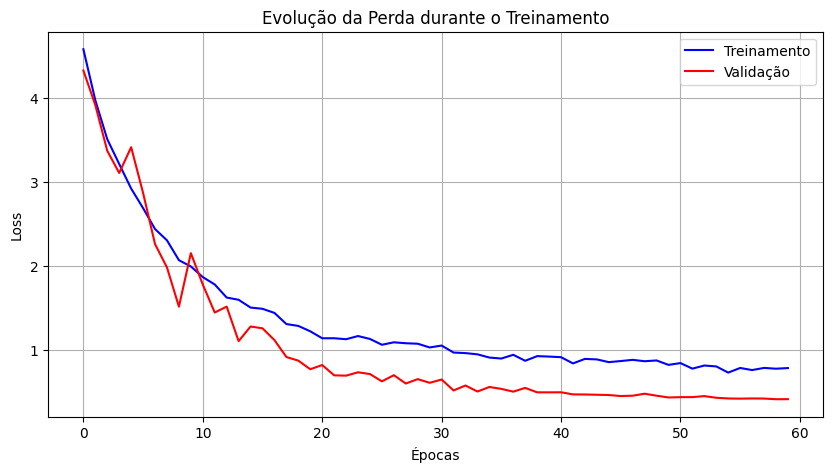

1/1 [==============================] - 0s 18ms/step
Fold 1 - Acurácia: 85.67%
Fold 1 - Precisão (macro): 85.54%
Fold 1 - Revocação (macro): 87.93%
Fold 1 - F1-score (macro): 84.76%
              precision    recall  f1-score   support

           0       0.62      0.89      0.73         9
           1       0.41      0.88      0.56         8
           2       0.00      0.00      0.00        13
           3       0.71      0.92      0.80        13
           4       1.00      0.21      0.35        14
           5       0.56      1.00      0.72         9
           6       1.00      1.00      1.00         8
           7       1.00      1.00      1.00        11
           8       0.36      0.73      0.48        11
           9       0.40      0.12      0.19        16
          10       1.00      1.00      1.00        11
          11       1.00      1.00      1.00        19
          12       1.00      1.00      1.00        10
          13       1.00      1.00      1.00        15
        

d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Libr

Epoch 1/60
81/81 [==============================] - 24s 276ms/step - loss: 4.5689 - accuracy: 0.0827 - val_loss: 4.3608 - val_accuracy: 0.1031 - lr: 0.0010
Epoch 2/60
81/81 [==============================] - 22s 269ms/step - loss: 3.9336 - accuracy: 0.1546 - val_loss: 4.1759 - val_accuracy: 0.0625 - lr: 0.0010
Epoch 3/60
81/81 [==============================] - 22s 270ms/step - loss: 3.5419 - accuracy: 0.1944 - val_loss: 3.4856 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/60
81/81 [==============================] - 22s 272ms/step - loss: 3.1409 - accuracy: 0.2724 - val_loss: 3.0370 - val_accuracy: 0.4000 - lr: 0.0010
Epoch 5/60
81/81 [==============================] - 22s 277ms/step - loss: 2.8495 - accuracy: 0.3435 - val_loss: 2.5791 - val_accuracy: 0.4531 - lr: 0.0010
Epoch 6/60
81/81 [==============================] - 22s 270ms/step - loss: 2.6129 - accuracy: 0.3864 - val_loss: 2.5700 - val_accuracy: 0.3219 - lr: 0.0010
Epoch 7/60
81/81 [==============================] - 22s 270ms/st

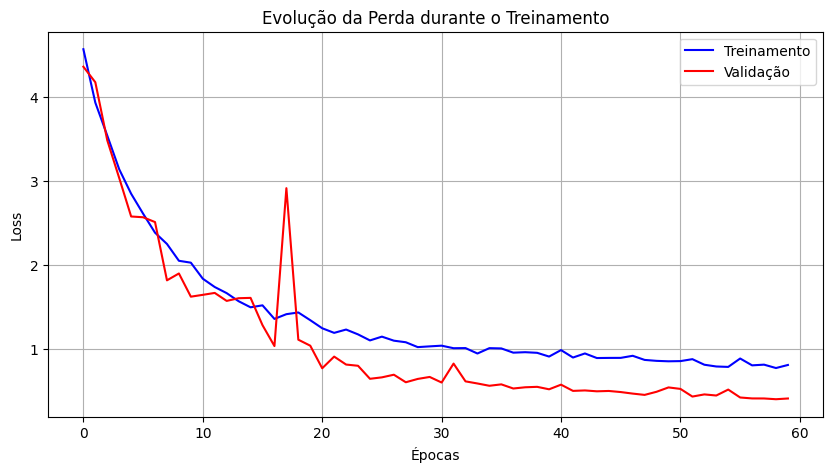

1/1 [==============================] - 0s 20ms/step
Fold 2 - Acurácia: 83.44%
Fold 2 - Precisão (macro): 80.53%
Fold 2 - Revocação (macro): 83.43%
Fold 2 - F1-score (macro): 80.28%
              precision    recall  f1-score   support

           0       0.67      0.44      0.53         9
           1       0.00      0.00      0.00        13
           2       0.26      0.86      0.40         7
           3       1.00      0.62      0.77         8
           4       0.20      0.09      0.12        11
           5       0.39      0.78      0.52         9
           6       1.00      1.00      1.00        12
           7       1.00      1.00      1.00        10
           8       0.00      0.00      0.00        11
           9       0.42      1.00      0.59         8
          10       1.00      1.00      1.00         8
          11       0.92      1.00      0.96        11
          12       1.00      1.00      1.00         8
          13       1.00      1.00      1.00        11
        

d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Libr

Epoch 1/60
81/81 [==============================] - 23s 273ms/step - loss: 4.5051 - accuracy: 0.1062 - val_loss: 4.3044 - val_accuracy: 0.0812 - lr: 0.0010
Epoch 2/60
81/81 [==============================] - 22s 267ms/step - loss: 3.9012 - accuracy: 0.1756 - val_loss: 3.8318 - val_accuracy: 0.2406 - lr: 0.0010
Epoch 3/60
81/81 [==============================] - 22s 270ms/step - loss: 3.4660 - accuracy: 0.2326 - val_loss: 3.5358 - val_accuracy: 0.1469 - lr: 0.0010
Epoch 4/60
81/81 [==============================] - 22s 268ms/step - loss: 3.0968 - accuracy: 0.3029 - val_loss: 3.0731 - val_accuracy: 0.3281 - lr: 0.0010
Epoch 5/60
81/81 [==============================] - 22s 268ms/step - loss: 2.8159 - accuracy: 0.3513 - val_loss: 2.4717 - val_accuracy: 0.4906 - lr: 0.0010
Epoch 6/60
81/81 [==============================] - 22s 267ms/step - loss: 2.6183 - accuracy: 0.3489 - val_loss: 2.5572 - val_accuracy: 0.3562 - lr: 0.0010
Epoch 7/60
81/81 [==============================] - 22s 266ms/st

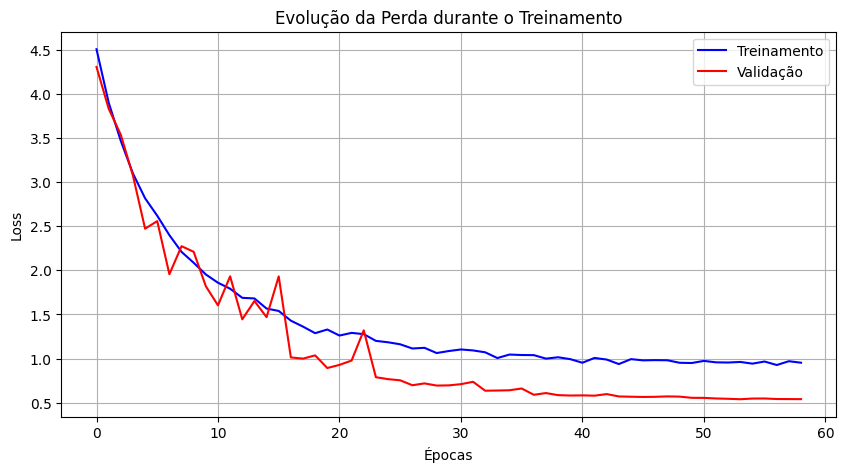

1/1 [==============================] - 0s 20ms/step
Fold 3 - Acurácia: 82.19%
Fold 3 - Precisão (macro): 82.88%
Fold 3 - Revocação (macro): 83.35%
Fold 3 - F1-score (macro): 82.30%
              precision    recall  f1-score   support

           0       0.00      0.00      0.00        14
           1       0.08      0.08      0.08        12
           2       0.17      0.44      0.25         9
           3       1.00      0.56      0.71         9
           4       0.62      0.62      0.62        13
           5       0.69      0.92      0.79        12
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         9
           8       0.40      0.67      0.50         9
           9       0.50      0.25      0.33        12
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00         9
          12       1.00      1.00      1.00        12
          13       1.00      1.00      1.00         7
        

d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Libr

Epoch 1/60
81/81 [==============================] - 24s 279ms/step - loss: 4.4760 - accuracy: 0.1116 - val_loss: 4.3514 - val_accuracy: 0.0844 - lr: 0.0010
Epoch 2/60
81/81 [==============================] - 22s 272ms/step - loss: 3.8569 - accuracy: 0.1858 - val_loss: 3.9222 - val_accuracy: 0.1531 - lr: 0.0010
Epoch 3/60
81/81 [==============================] - 22s 271ms/step - loss: 3.4519 - accuracy: 0.2311 - val_loss: 3.4031 - val_accuracy: 0.3156 - lr: 0.0010
Epoch 4/60
81/81 [==============================] - 22s 274ms/step - loss: 3.0990 - accuracy: 0.2842 - val_loss: 2.9036 - val_accuracy: 0.4062 - lr: 0.0010
Epoch 5/60
81/81 [==============================] - 22s 272ms/step - loss: 2.8632 - accuracy: 0.3372 - val_loss: 2.6682 - val_accuracy: 0.3594 - lr: 0.0010
Epoch 6/60
81/81 [==============================] - 22s 270ms/step - loss: 2.6255 - accuracy: 0.3630 - val_loss: 2.3915 - val_accuracy: 0.4688 - lr: 0.0010
Epoch 7/60
81/81 [==============================] - 22s 271ms/st

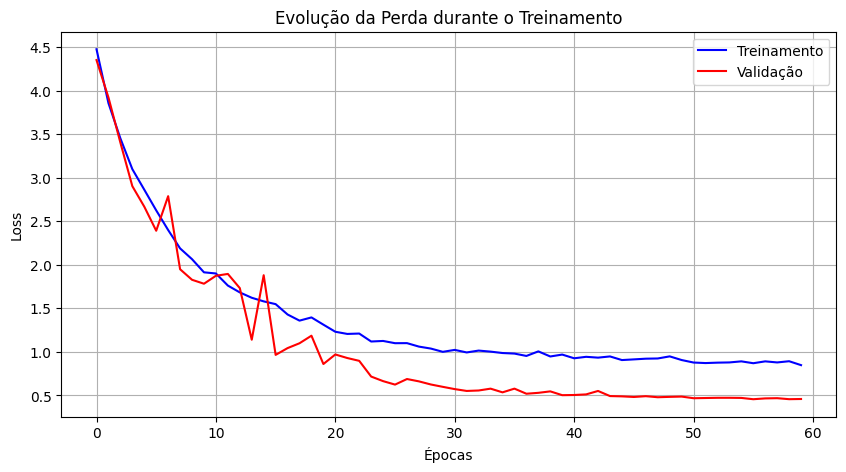

1/1 [==============================] - 0s 20ms/step
Fold 4 - Acurácia: 84.38%
Fold 4 - Precisão (macro): 81.10%
Fold 4 - Revocação (macro): 82.07%
Fold 4 - F1-score (macro): 80.40%
              precision    recall  f1-score   support

           0       0.33      0.33      0.33         9
           1       0.42      0.42      0.42        12
           2       0.38      0.38      0.38        13
           3       1.00      0.50      0.67        12
           4       0.22      0.67      0.33         6
           5       0.00      0.00      0.00         8
           6       1.00      1.00      1.00         6
           7       1.00      1.00      1.00        17
           8       0.00      0.00      0.00         8
           9       0.50      1.00      0.67         8
          10       1.00      1.00      1.00        13
          11       1.00      1.00      1.00        15
          12       1.00      1.00      1.00        13
          13       1.00      1.00      1.00        13
        

d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Libr

Epoch 1/60
81/81 [==============================] - 24s 273ms/step - loss: 4.5496 - accuracy: 0.1093 - val_loss: 4.3432 - val_accuracy: 0.0969 - lr: 0.0010
Epoch 2/60
81/81 [==============================] - 22s 268ms/step - loss: 3.8813 - accuracy: 0.1639 - val_loss: 3.9904 - val_accuracy: 0.0875 - lr: 0.0010
Epoch 3/60
81/81 [==============================] - 22s 268ms/step - loss: 3.4767 - accuracy: 0.2209 - val_loss: 3.5056 - val_accuracy: 0.2500 - lr: 0.0010
Epoch 4/60
81/81 [==============================] - 22s 270ms/step - loss: 3.1401 - accuracy: 0.2779 - val_loss: 3.2733 - val_accuracy: 0.1750 - lr: 0.0010
Epoch 5/60
81/81 [==============================] - 22s 268ms/step - loss: 2.8553 - accuracy: 0.3201 - val_loss: 3.0848 - val_accuracy: 0.1844 - lr: 0.0010
Epoch 6/60
81/81 [==============================] - 22s 269ms/step - loss: 2.5903 - accuracy: 0.3489 - val_loss: 2.2942 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 7/60
81/81 [==============================] - 22s 269ms/st

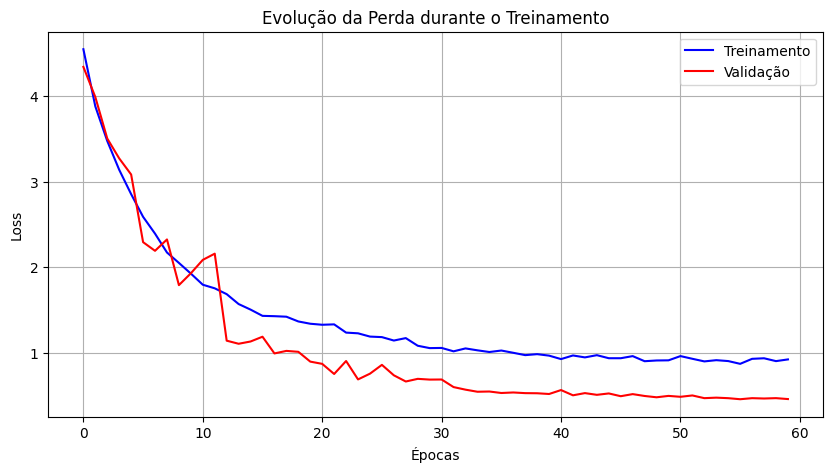

1/1 [==============================] - 0s 20ms/step
Fold 5 - Acurácia: 85.00%
Fold 5 - Precisão (macro): 85.97%
Fold 5 - Revocação (macro): 84.52%
Fold 5 - F1-score (macro): 80.98%
              precision    recall  f1-score   support

           0       1.00      0.10      0.18        10
           1       0.26      1.00      0.41         7
           2       0.00      0.00      0.00        11
           3       1.00      0.44      0.62         9
           4       0.33      1.00      0.50         8
           5       0.00      0.00      0.00        11
           6       1.00      1.00      1.00        11
           7       1.00      1.00      1.00         5
           8       1.00      0.18      0.31        11
           9       0.53      1.00      0.69        10
          10       1.00      1.00      1.00        14
          11       1.00      1.00      1.00         7
          12       1.00      1.00      1.00        14
          13       1.00      1.00      1.00        10
        

d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\LibrasUfop-skeleton\meu_ambiente\lib\site-packages\sklearn\metrics\_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
d:\Libr

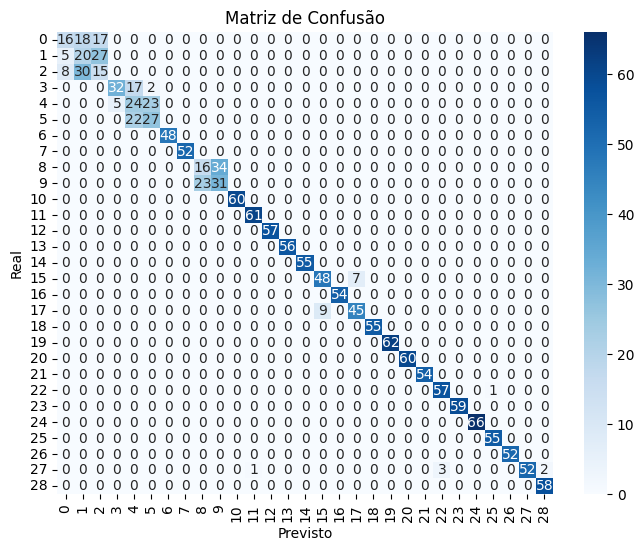

In [12]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, Masking
from tensorflow.keras.layers import LayerNormalization, MultiHeadAttention, GlobalAveragePooling1D
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Função para construir o modelo Transformer
def build_transformer_with_attention(max_seq_length, feature_dim, num_classes, num_heads=4, key_dim=16):
    """
    Modelo Transformer com Multi-Head Attention, regularizações e menos camadas fully connected.
    """
    # Entrada
    inputs = Input(shape=(max_seq_length, feature_dim), name='skeleton_input')
    x = Masking(mask_value=0.0)(inputs)  # Máscara para ignorar padding
    
    # Embedding Posicional
    position_embedding = tf.keras.layers.Embedding(input_dim=max_seq_length, output_dim=feature_dim)(tf.range(max_seq_length))
    x = x + position_embedding  # Soma de embeddings de posição com as entradas
    
    # Bloco de atenção multi-cabeça
    attention_output = MultiHeadAttention(num_heads=num_heads, key_dim=key_dim)(x, x)
    x = LayerNormalization()(x + attention_output)  # Residual connection e normalização
    
    # Camada densa com regularização L2 e Dropout
    x = Dense(64, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    # Redução da dimensão temporal
    x = GlobalAveragePooling1D()(x)  # Média ao longo da dimensão temporal
    
    # Camada fully connected final com regularização L2 e Dropout
    x = Dense(32, activation='relu', kernel_regularizer=l2(0.01))(x)
    x = Dropout(0.5)(x)
    x = BatchNormalization()(x)
    
    # Saída
    outputs = Dense(num_classes, activation='softmax')(x)
    
    # Criação do modelo
    model = Model(inputs, outputs)
    return model

# Função para plotar as curvas de perda
def plot_losses(history):
    plt.figure(figsize=(10, 5))
    plt.plot(history.history['loss'], label='Treinamento', color='blue')
    plt.plot(history.history['val_loss'], label='Validação', color='red')
    plt.xlabel('Épocas')
    plt.ylabel('Loss')
    plt.title('Evolução da Perda durante o Treinamento')
    plt.legend()
    plt.grid(True)
    plt.show()

# Função para plotar a matriz de confusão
def plot_confusion_matrix(y_true, y_pred, labels):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.xlabel("Previsto")
    plt.ylabel("Real")
    plt.title("Matriz de Confusão")
    plt.show()

# Função para realizar a validação cruzada K-Fold e avaliação
def kfold_cross_validation(dataset, max_seq_length, feature_dim, num_classes, n_splits=5, epochs=20, batch_size=16):
    """
    Realiza validação cruzada K-Fold no conjunto de dados e avalia o modelo.
    """
    kfold = KFold(n_splits=n_splits, shuffle=True)
    results = []
    y_true_all, y_pred_all = [], []

    # Iterar sobre os folds
    for fold, (train_idx, val_idx) in enumerate(kfold.split(dataset.samples)):
        print(f"\nFold {fold + 1}/{n_splits}")
        
        # Dividir os dados em treino e validação
        train_samples = [dataset.samples[i] for i in train_idx]
        val_samples = [dataset.samples[i] for i in val_idx]
        
        # Criar datasets de treino e validação
        train_dataset = SkeletonSequenceDataset(
            dataset_root=dataset.dataset_root,
            subjects=dataset.subjects,
            batch_size=batch_size,
            shuffle=True,
            max_seq_length=max_seq_length,
            num_joints=dataset.num_joints,
            center_joint_index=dataset.center_joint_index
        )
        train_dataset.samples = train_samples
        
        val_dataset = SkeletonSequenceDataset(
            dataset_root=dataset.dataset_root,
            subjects=dataset.subjects,
            batch_size=batch_size,
            shuffle=False,
            max_seq_length=max_seq_length,
            num_joints=dataset.num_joints,
            center_joint_index=dataset.center_joint_index
        )
        val_dataset.samples = val_samples
        
        # Construir e compilar o modelo
        model = build_transformer_with_attention(max_seq_length, feature_dim, num_classes)
        model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
        
        # Callbacks
        callbacks = [
            tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True),
            tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
        ]
        
        # Treinar o modelo
        history = model.fit(
            train_dataset,
            validation_data=val_dataset,
            epochs=epochs,
            callbacks=callbacks,
            verbose=1
        )
        
        # Plotar curvas de perda
        plot_losses(history)
        
        # Avaliar o modelo no fold de validação
        y_true, y_pred = [], []
        for X_batch, y_batch in val_dataset:
            y_batch_true = np.argmax(y_batch, axis=1)  # Converter one-hot para índice
            y_batch_pred = np.argmax(model.predict(X_batch), axis=1)
            y_true.extend(y_batch_true)
            y_pred.extend(y_batch_pred)
        
        # Armazenar resultados
        y_true_all.extend(y_true)
        y_pred_all.extend(y_pred)
        
        # Calcular métricas para o fold atual
        accuracy = accuracy_score(y_true, y_pred) * 100
        precision = precision_score(y_true, y_pred, average='macro') * 100
        recall = recall_score(y_true, y_pred, average='macro') * 100
        f1 = f1_score(y_true, y_pred, average='macro') * 100
        
        print(f"Fold {fold + 1} - Acurácia: {accuracy:.2f}%")
        print(f"Fold {fold + 1} - Precisão (macro): {precision:.2f}%")
        print(f"Fold {fold + 1} - Revocação (macro): {recall:.2f}%")
        print(f"Fold {fold + 1} - F1-score (macro): {f1:.2f}%")
        print(classification_report(y_true, y_pred, digits=2))
        
        results.append(accuracy)
    
    # Resultados finais
    print(f"\nAcurácia média: {np.mean(results):.4f}% (±{np.std(results):.4f})")
    
    # Plotar matriz de confusão para todos os folds
    plot_confusion_matrix(y_true_all, y_pred_all, labels=[str(i) for i in range(num_classes)])

# Parâmetros
MAX_SEQ_LENGTH = 100
NUM_JOINTS = 25
FEATURE_DIM = NUM_JOINTS * 3 * 3  # Considerando derivadas temporais
BATCH_SIZE = 16
EPOCHS = 60
N_SPLITS = 5  # Número de folds para a validação cruzada

# Criar o dataset completo
dataset = SkeletonSequenceDataset(
    dataset_root="D:\LibrasUfop-skeleton\LibrasUfop-skeleton",
    subjects=None,  # Usar todos os sujeitos
    batch_size=BATCH_SIZE,
    shuffle=True,
    max_seq_length=MAX_SEQ_LENGTH,
    num_joints=NUM_JOINTS,
    center_joint_index=0
)

# Executar validação cruzada K-Fold e avaliação
kfold_cross_validation(dataset, MAX_SEQ_LENGTH, FEATURE_DIM, dataset.num_classes, n_splits=N_SPLITS, epochs=EPOCHS, batch_size=BATCH_SIZE)

In [3]:
a= 7
a.__str__()

'7'